## This script introduces filtered backprojection (FBP) recosntruction

#### Import python package 

In [1]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import torch

plt.style.use("dark_background")
plt.rcParams['image.cmap'] = 'gray'

#### Import CTorch package 

In [2]:
import CTorch.utils.geometry as geometry
from CTorch.projector.projector_interface import Projector
from CTorch.reconstructor.fbpreconstructor import FBPReconstructor  as FBP

#### Define [geometry](./2_geometry.ipynb)

Here we take 2D geometry as an example, fbp with 3D geoemtry can be done in the same way

In [3]:
nx, ny = 512,512 # image dimension
dx, dy = 0.8, 0.8 # image pixel size

nu = 1024 # detector length 
du = 1.0 # detecor pixel size
nView = 720 # number of views
viewAngles = np.arange(0,-2*np.pi,-2*np.pi/nView) # projection angle
detType = 'curve' #'curve'
SAD, SDD = [800.0], [1200.0] # source-axis-distance, source-detector-distance

xOfst, yOfst = [0.0], [0.0] # image center offset
uOfst = [0.0] # detecor center offset
xSrc = [100.0]

# define geometry object
geom = geometry.Geom2D(nx, ny, dx, dy, nu, nView, viewAngles, du, detType, SAD, SDD, 
                 xOfst = xOfst, yOfst = yOfst, uOfst = uOfst, xSrc = xSrc, fixed=True)  


#### Define [projector](3_projector.ipynb) and reconstructor

FBP Reconstructor can be instantiated by: FBP(geom, projAlgo, cutoff, window)

- "geom" represents the geometry object, which can be 2D, circualr 3D, or noncircualr 3D geometry

- "projAlgo" specifies the backprojector algorithm used. Options: ["voxel"](https://books.google.com/books?hl=en&lr=&id=JX__lLLXFHkC&oi=fnd&pg=PR9&dq=jiang+hsieh&ots=RmO41mS0_u&sig=_boSppBiZxN6eoc6A393a6lLqBA#v=onepage&q=jiang%20hsieh&f=false), ["ray"](https://hrcak.srce.hr/clanak/221195), ["DD"](https://iopscience.iop.org/article/10.1088/0031-9155/49/11/024/meta), ["SF"](https://ieeexplore.ieee.org/abstract/document/5482021). "DD" and "SF" are the most accurate projectors while "voxel" and "ray" may provide higher computational efficiency.

- "cutoff" defines the cutoff frequency (unit: Nyquist frequency, set ramp filter to zero for the the frequency larger than the cutoff frequency)

- "window" defines the [window function](https://en.wikipedia.org/wiki/Window_function) used in FBP reconstruction. Options: ['hamming','blackman','hann','bartlett','kaiser', or user-defined vector]

In [4]:
projAlgo = 'SF' 
reconAlgo = 'SF' 
A = Projector(geom,'proj', projAlgo,'forward')
AT = Projector(geom,'proj', projAlgo,'back') 

Recon = FBP(geom, reconAlgo, window="hamming", cutoff=0.95)

#### Load example data

In [5]:
batch_size = 32 # number of images per batch
channel_size = 3 # number of image channels

img = io.loadmat("img_example.mat")["img"]
img = torch.Tensor(img).reshape([1,1,ny,nx]).cuda()
img = img.repeat(batch_size, channel_size, 1, 1)

img[:,:,300,300] = 100.0

In [6]:
img[0,0,256,256]

tensor(0.0230, device='cuda:0')

#### Execute sinogram simulation and FBP reconstruction

**NOTE**: If batch_size and channel_size is not 1, all the batches and channels will be reconstructed simultaneously.

In [7]:
sino = A(img)
imgb = AT(sino)
imgr = Recon(sino)

#### Display results

In [8]:
sino = sino.squeeze().cpu().detach().numpy()
imgr = imgr.squeeze().cpu().detach().numpy()
imgb = imgb.squeeze().cpu().detach().numpy()
img = img.squeeze().cpu().detach().numpy()

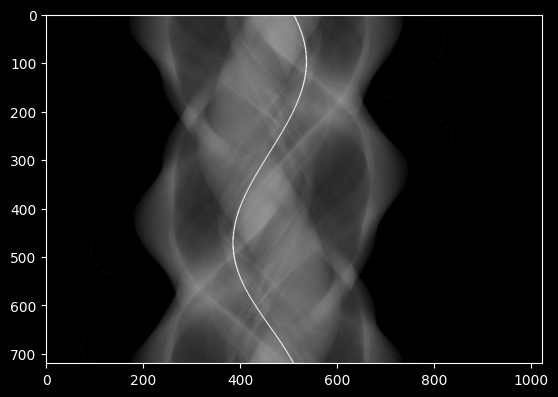

In [9]:
plt.imshow(sino[0, 0], vmin=0, vmax=10)

Text(0.5, 1.0, 'From left to right: backprojection, filtered backprojection, ground truth')

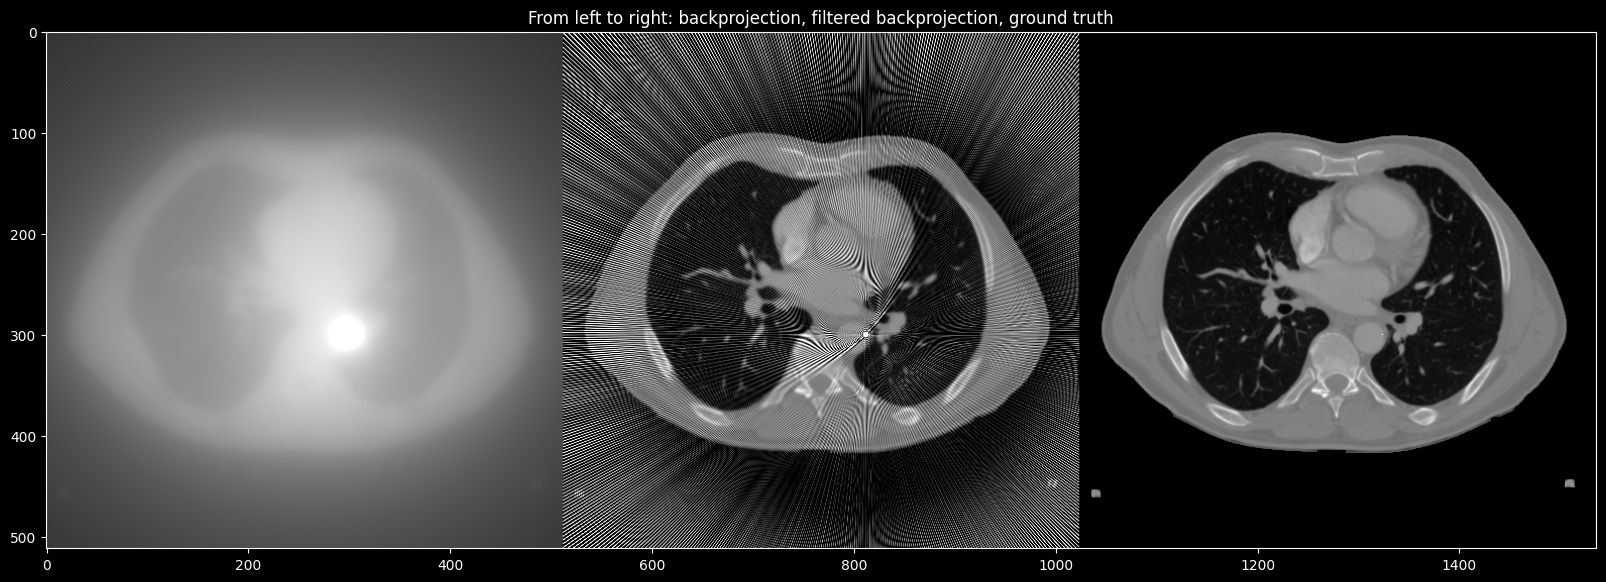

In [10]:
plt.figure(figsize=(20, 20))
plt.imshow(np.hstack((imgb[0,0]*1e-5,imgr[1,1],img[0,0])),vmin = 0.00,vmax=0.04)
plt.title('From left to right: backprojection, filtered backprojection, ground truth')